# DIS/Pyprob/Ginkgo Tests

In [1]:
import pyprob
import numpy as np
import torch

from pyprob.dis import ModelDIS
from showerSim import invMass_ginkgo

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as mpl_cm
plt.ion()

import sklearn as skl
from sklearn.linear_model import LinearRegression

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [41]:
obs_leaves = torch.tensor([[16.41187477, 10.33649503, 10.69404072,  6.33743888],
       [ 6.05119602,  3.53805029,  4.58600313,  1.75058085],
       [14.90228798,  5.34797505, 10.80988287,  8.36754207],
       [58.79304385, 34.38227241, 44.24563837, 17.74093297],
       [30.24481564, 19.01268437, 15.46620115, 17.70062201],
       [38.2342777 , 17.16874044, 22.46647358, 25.55421501],
       [18.56857186,  8.96516026,  9.59710653, 13.10520213],
       [36.30779283, 24.5448835 , 20.439264  , 17.25162816],
       [40.09604598, 19.87731754, 23.20830837, 25.89297908],
       [62.59783825, 37.85734405, 28.81331253, 40.63675002],
       [85.71382246, 49.90918831, 40.6138786 , 56.6022217 ]], dtype=torch.float64)

# Define initial conditions for the simulator

jetM = 80. # parent mass -> W
jetdir = np.array([1,1,1]) # direction
jetP = 400. # magnitude
jetvec = jetP * jetdir / np.linalg.norm(jetdir)

jet4vec = np.concatenate(([np.sqrt(jetP**2 + jetM**2)], jetvec))

# Define a function that takes (self, jet) and outputs True for the condition we want
def dummy_bernoulli(self, jet):
    return True

def get_subjet_pT(jet, side="left"):
    if side == "left":
        subjet_left_4vec = jet["content"][jet["tree"][0][0]]
        subjet_left_pT = np.sqrt(subjet_left_4vec[1]**2 + subjet_left_4vec[2]**2)
        return subjet_left_pT
    elif side == "right":
        subjet_right_4vec = jet["content"][jet["tree"][0][1]]
        subjet_right_pT= np.sqrt(subjet_right_4vec[1]**2 + subjet_right_4vec[2]**2)
        return subjet_right_pT
    return None

def subjet_pT_cut(self, jet):
    subjet_left_4vec = jet["content"][jet["tree"][0][0]]
    subjet_right_4vec = jet["content"][jet["tree"][0][1]]
    subjet_left_pT = np.sqrt(subjet_left_4vec[1]**2 + subjet_left_4vec[2]**2)
    subjet_right_pT= np.sqrt(subjet_right_4vec[1]**2 + subjet_right_4vec[2]**2)
    #return (275 <= subjet_left_pT <= 400) or (275 <= subjet_right_pT <= 400)
    return (subjet_left_pT <= 40) and (270 <= subjet_right_pT)

class SimulatorModelDIS(invMass_ginkgo.SimulatorModel, ModelDIS):
    pass

simulator = SimulatorModelDIS(rate=[3, 1.5], # exponential dsitribution rate
                              jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=10.,  # minimum pT for resulting jet
                              Delta_0=torch.tensor(jetM**2),  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=0,  # minimum number of jet constituents
                              maxLeaves=1000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              bool_func=dummy_bernoulli,
                              suppress_output=True,
                              obs_leaves=obs_leaves)

In [42]:
#%cd ~/DISPyprob
simulator.train(
    importance_sample_size=5000, # Small size for testing!
    proposal_mixture_components=3,
    observe_embeddings={'bool_func': {'dim': 1, 'depth': 1}} # Dummy value as we currently have to observe something
) 

simulator.save_inference_network('Ginkgo_inference_network_2')

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------------------------ |   69/5000 |  57.39 | 15.15       


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:300: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


------------------------------#----------------- |  651/5000 | 558.53 | 15.10       
------------------------------#----------------- |  754/5000 | 647.71 | 15.09       
------------------------------###########------- | 3344/5000 | 2893.07 | 14.72       
------------------------------################-- | 4456/5000 | 3859.42 | 14.13       
------------------------------#################- | 4652/5000 | 4026.72 | 14.08       
0d:00:06:14 | 0d:00:00:00 | #################### | 5000/5000 | 4328.23 | 13.34       
OfflineDataset at: .
Num. traces      : 100
Sorted on disk   : False
No pre-computed hashes found, generating: ./pyprob_hashes
Hashing offline dataset for sorting
Time spent  | Time remain.| Progress             | Traces  | Traces/sec
0d:00:00:01 | 0d:00:00:00 | #################### | 100/100 | 78.51       
Sorting offline dataset
Sorting done
Num. trace types : 90
Trace hash	Count
36.15205383	1
36.16402817	1
36.82762146	1
36.84504318	1
40.10576248	1
40.11539078	1
40.12026978	1
40.

/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:346: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )
/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:468: UserWarning: nan detected in obs_leaves, returning distance of 1e6
  warn("nan detected in obs_leaves, returning distance of 1e6")


------------------------------#############----- | 3811/5000 | 3297.44 | 12.86       
0d:00:06:32 | 0d:00:00:00 | #################### | 5000/5000 | 4330.24 | 12.74       
OfflineDataset at: .
Num. traces      : 100
Sorted on disk   : False
No pre-computed hashes found, generating: ./pyprob_hashes
Hashing offline dataset for sorting
Time spent  | Time remain.| Progress             | Traces  | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 100/100 | 38.41       
Sorting offline dataset
Sorting done
Num. trace types : 90
Trace hash	Count
36.15205383	1
36.16402817	1
36.82762146	1
36.84504318	1
40.10576248	1
40.11539078	1
40.12026978	1
40.13689804	1
40.14674759	2
40.16831207	1
40.18172836	1
40.75627899	1
40.76779556	2
40.79339981	1
40.80806732	1
40.91818619	1
44.13692856	1
44.14089203	3
44.14792252	1
44.15736008	1
44.16753006	1
44.17617416	1
44.17839813	1
44.26420593	1
44.38117218	1
44.44247818	1
44.49607849	1
44.57316208	1
44.93465042	1
44.95565796	1
45.14334106	1
45.163009

In [43]:
posterior = simulator.posterior_results(
                                         num_traces=1000, # the number of samples estimating the posterior
                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                                         observe={'bool_func': 1} # assign values to the observed values
                                         )

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------################-- |  902/1000 | 784.06 | 13.41       


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:299: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pL inv mass from p^2 in lab  frame: {np.sqrt(pL_mu[0]**2-np.linalg.norm(pL_mu[1::])**2)}")


0d:00:01:14 | 0d:00:00:00 | #################### | 1000/1000 | 868.19 | 13.47       


In [5]:
posterior.values[0].keys()

dict_keys(['root_id', 'tree', 'content', 'LambdaRoot', 'Lambda', 'Delta_0', 'pt_cut', 'algorithm', 'deltas', 'draws', 'leaves', 'M_Hard'])

## Histograms
Start with a histogram of leaf count

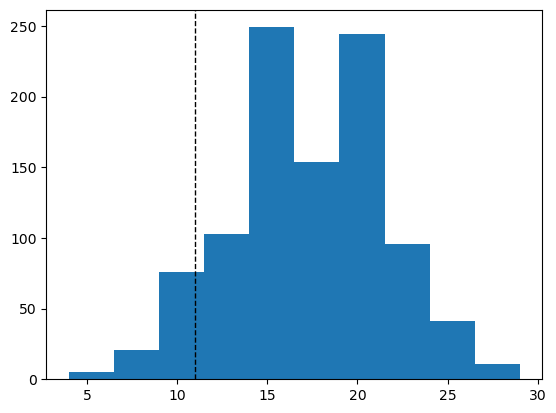

In [44]:
leaf_counts = [len(x['leaves']) for x in posterior.values]
plt.hist(leaf_counts)
plt.axvline(len(obs_leaves), color='k', linestyle='dashed', linewidth=1)
plt.show()

This is a bit peculiar.

In [50]:
prior=simulator.prior_results(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | ESS    | Traces/sec
------------------------------###############--- |  836/1000 | 718.65 | 10.82       


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:300: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


0d:00:01:29 | 0d:00:00:00 | #################### | 1000/1000 | 861.69 | 11.14       


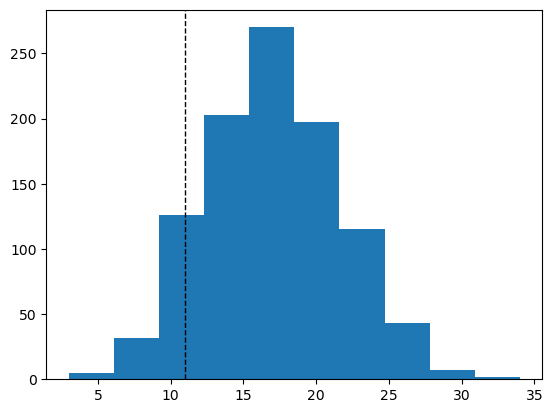

In [51]:
leaf_counts = [len(x['leaves']) for x in prior.values]
plt.hist(leaf_counts)
plt.axvline(len(obs_leaves), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Raw simulations

In [23]:
raw_simulator = SimulatorModelDIS(rate=[3, 1.5], # exponential dsitribution rate
                              jet_p=jet4vec,  # parent particle 4-vector
                              pt_cut=10.,  # minimum pT for resulting jet
                              Delta_0=torch.tensor(jetM**2),  # parent particle mass squared -> needs tensor
                              M_hard=jetM,  # parent particle mass
                              minLeaves=0,  # minimum number of jet constituents
                              maxLeaves=1000,  # maximum number of jet constituents (a large value to stop expensive simulator runs)
                              bool_func=dummy_bernoulli,
                              suppress_output=True,
                              obs_leaves=obs_leaves)

In [25]:
raw_data = [raw_simulator([3.0,1.5]) for i in range(1000)]

------------------------------


/mnt/c/Users/Sammy/OneDrive - University of Bristol/ToyJetsShower/showerSim/invMass_ginkgo.py:300: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")


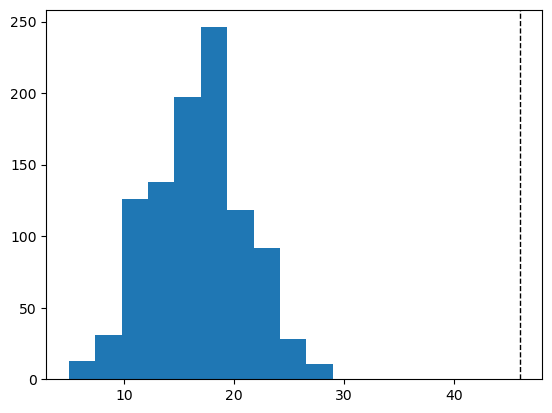

In [26]:
leaf_counts = [len(x['leaves']) for x in raw_data]
plt.hist(leaf_counts)
plt.axvline(len(obs_leaves), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [27]:
raw_data2 = [raw_simulator([3.0,3.0]) for i in range(1000)]

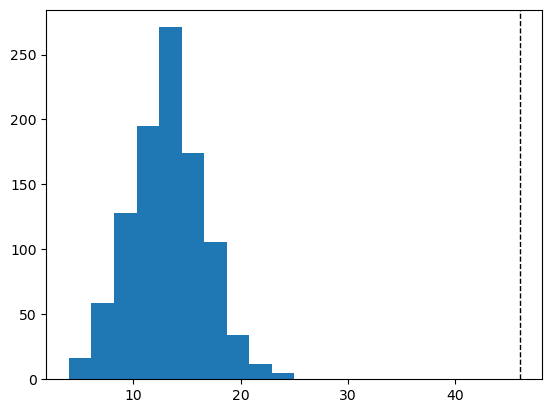

In [28]:
leaf_counts = [len(x['leaves']) for x in raw_data2]
plt.hist(leaf_counts)
plt.axvline(len(obs_leaves), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [29]:
simulator3 = invMass_ginkgo.Simulator(jet_p=jet4vec,
                                     pt_cut=10,
                                     Delta_0=torch.tensor(jetM**2),
                                     M_hard=jetM ,
                                     num_samples=1,
                                     minLeaves =0,
                                     maxLeaves = 1000,
                                     maxNTry = 1
                                     )

In [ ]:
raw_data3 = [simulator3([3.0,3.0]) for i in range(1000)]

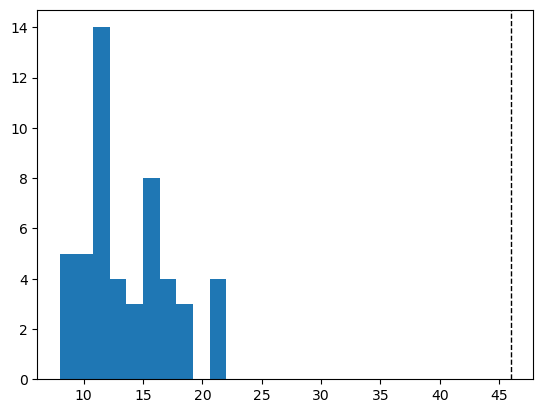

In [38]:
leaf_counts = [len(x[0]['leaves']) for x in raw_data3]
plt.hist(leaf_counts)
plt.axvline(len(obs_leaves), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [40]:
simulator3([3.0,3.0])[0]['leaves']

2022-01-14 13:39:54,747:INFO::Num samples: 1
2022-01-14 13:39:54,748:INFO::Initial squared mass: 6400.0
2022-01-14 13:39:54,755:INFO:: Off-shell subjets mass = (tensor(41.4717), tensor(23.0161))
2022-01-14 13:39:54,779:INFO:: Leaves  = [[16.41187477 10.33649503 10.69404072  6.33743888]
 [ 6.05119602  3.53805029  4.58600313  1.75058085]
 [14.90228798  5.34797505 10.80988287  8.36754207]
 [58.79304385 34.38227241 44.24563837 17.74093297]
 [30.24481564 19.01268437 15.46620115 17.70062201]
 [38.2342777  17.16874044 22.46647358 25.55421501]
 [18.56857186  8.96516026  9.59710653 13.10520213]
 [36.30779283 24.5448835  20.439264   17.25162816]
 [40.09604598 19.87731754 23.20830837 25.89297908]
 [62.59783825 37.85734405 28.81331253 40.63675002]
 [85.71382246 49.90918831 40.6138786  56.6022217 ]]
2022-01-14 13:39:54,780:INFO:: N const = 11
2022-01-14 13:39:54,782:INFO:: Total momentum from root = [407.92156109 230.94010768 230.94010768 230.94010768]
2022-01-14 13:39:54,783:INFO:: Total momentum 

 N const =  11


array([[16.41187477, 10.33649503, 10.69404072,  6.33743888],
       [ 6.05119602,  3.53805029,  4.58600313,  1.75058085],
       [14.90228798,  5.34797505, 10.80988287,  8.36754207],
       [58.79304385, 34.38227241, 44.24563837, 17.74093297],
       [30.24481564, 19.01268437, 15.46620115, 17.70062201],
       [38.2342777 , 17.16874044, 22.46647358, 25.55421501],
       [18.56857186,  8.96516026,  9.59710653, 13.10520213],
       [36.30779283, 24.5448835 , 20.439264  , 17.25162816],
       [40.09604598, 19.87731754, 23.20830837, 25.89297908],
       [62.59783825, 37.85734405, 28.81331253, 40.63675002],
       [85.71382246, 49.90918831, 40.6138786 , 56.6022217 ]])